### ⭐ **Randomly** action Selection Comparision **without** Q Learnig VS **with** Q learnig

Results after 10000 episodes (Random Action):
Wins: 2794
Losses: 6776
Draws: 430
----------------------------------------
Win Percentage: 27.94%
Lose Percentage: 67.76%
Draw Percentage: 4.30%
****************************************
Results after 10000 episodes (Q-learning):
Wins: 3170
Losses: 6282
Draws: 548
----------------------------------------
Win Percentage: 31.70%
Lose Percentage: 62.82%
Draw Percentage: 5.48%


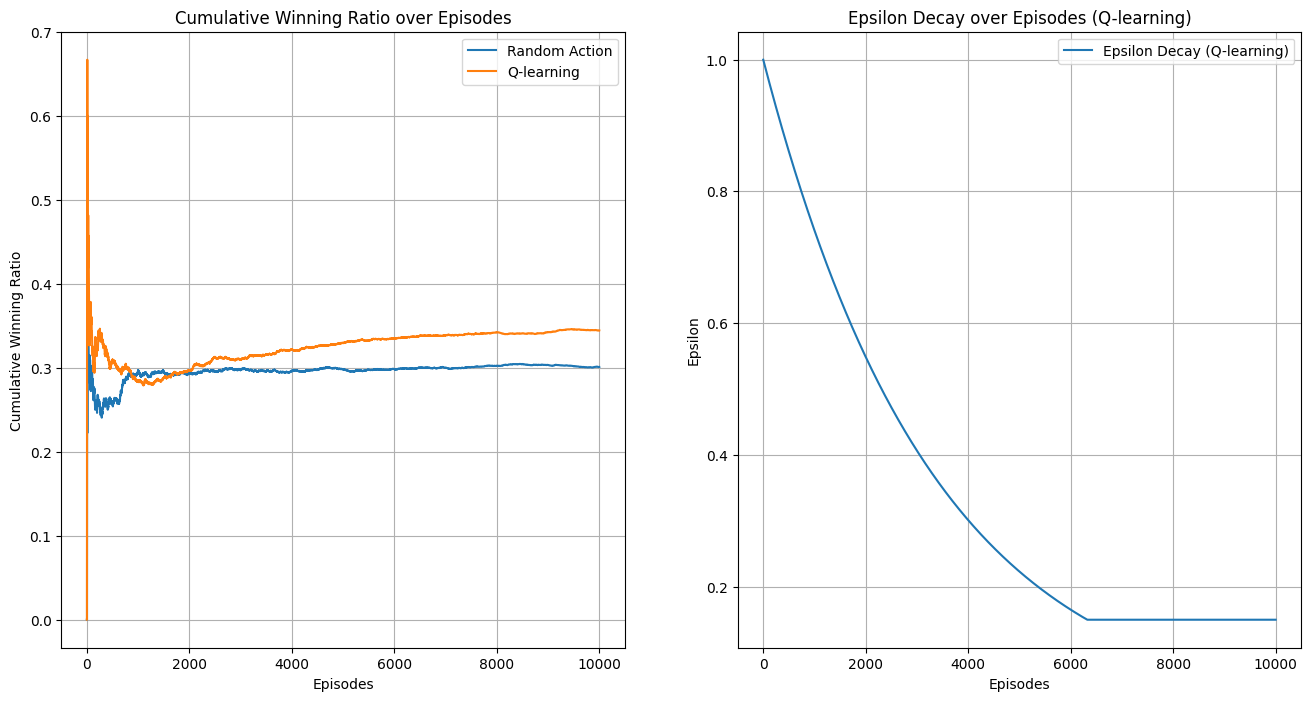

In [ ]:
import random  # import the random module for random number generation
import numpy as np  # import numpy for numerical operations
import matplotlib.pyplot as plt  # import matplotlib for plotting

class BlackjackEnvironmentRandom:
    def __init__(self, num_episodes=1000):
        # initialize card values and deck
        self.card_values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
        self.Deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        self.ACTIONS = ['hit', 'stand']  # Possible actions in Blackjack
        self.num_episodes = num_episodes  # number of episodes to run
        self.win_count = 0  # counter for wins
        self.lose_count = 0  # counter for losses
        self.draw_count = 0  # counter for draws
        self.cumulative_win = []  # list to store cumulative win ratio

    def deal_card(self, deck):
        # remove and return a card from the deck
        return deck.pop()

    def hand_value(self, hand):
        # Calculate the value of the hand
        value = sum(self.card_values[card] for card in hand)
        num_aces = hand.count('A')  # Count the number of Aces in the hand
        while value > 21 and num_aces:  # Adjust for Aces if value exceeds 21
            value -= 10
            num_aces -= 1
        return value

    def initialize_game(self):
        # Shuffle the deck and deal initial hands for player and dealer
        deck = self.Deck.copy()
        random.shuffle(deck)  # Shuffle the deck
        player_hand = [self.deal_card(deck), self.deal_card(deck)]  # deal two cards to player
        dealer_hand = [self.deal_card(deck), self.deal_card(deck)]  # deal two cards to dealer
        return deck, player_hand, dealer_hand

    def dealer_turn(self, deck, dealer_hand):
        # dealer's turn to draw cards until they reach at least 17
        while self.hand_value(dealer_hand) < 17:
            dealer_hand.append(self.deal_card(deck))
        return dealer_hand, self.hand_value(dealer_hand)

    def step(self, deck, player_hand, dealer_hand, action):
        # Execute a step of the game based on the action taken
        if action == 'hit':
            player_hand.append(self.deal_card(deck))  # Player draws a card
            if self.hand_value(player_hand) > 21:  # Check if the player busts
                reward = -1
                executed = True
            else:
                reward = 0
                executed = False
        else:  # action == 'stand'
            dealer_hand, dealer_total = self.dealer_turn(deck, dealer_hand)  # dealer's turn
            player_total = self.hand_value(player_hand)
            # Determine the result of the game
            if dealer_total > 21 or player_total > dealer_total:
                reward = 1
            elif player_total < dealer_total:
                reward = -1
            else:
                reward = 0
            executed = True

        if executed:
            # update counters based on the result
            if reward == 1:
                self.win_count += 1
            elif reward == -1:
                self.lose_count += 1
            else:
                self.draw_count += 1

            # Calculate and store the cumulative win ratio
            self.cumulative_win.append((self.win_count + 0.5 * self.draw_count) / (self.episode + 1))

        return deck, player_hand, dealer_hand, reward, executed

    def reset(self):
        # reset the game environment
        self.episode = 0
        self.win_count = 0
        self.lose_count = 0
        self.draw_count = 0
        self.cumulative_win = []

    def run_episodes(self):
        # run the game for a specified number of episodes
        self.reset()  # reset counters
        for self.episode in range(self.num_episodes):
            deck, player_hand, dealer_hand = self.initialize_game()  # initialize the game

            executed = False
            while not executed:
                action = random.choice(self.ACTIONS)  # choose a random action

                deck, player_hand, dealer_hand, reward, executed = self.step(deck, player_hand, dealer_hand, action)  # Take a step

        # Print the results of the simulation
        print(f"Results after {self.num_episodes} episodes (Random Action):")
        print(f"Wins: {self.win_count}")
        print(f"Losses: {self.lose_count}")
        print(f"Draws: {self.draw_count}")
        print("-"*40)

        total_games = self.win_count + self.lose_count + self.draw_count
        win_percentage = (self.win_count / total_games) * 100
        lose_percentage = (self.lose_count / total_games) * 100
        draw_percentage = (self.draw_count / total_games) * 100

        print(f"Win Percentage: {win_percentage:.2f}%")
        print(f"Lose Percentage: {lose_percentage:.2f}%")
        print(f"Draw Percentage: {draw_percentage:.2f}%")
        print("*"*40)

        return self.cumulative_win

class BlackjackEnvironmentQLearning:
    def __init__(self, num_episodes=1000):
        # initialize card values, deck, and Q-learning parameters
        self.card_values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
        self.Deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        self.ACTIONS = ['hit', 'stand']  # Possible actions in Blackjack
        self.alpha = 0.1  # learning rate
        self.gamma = 0.9  # discount factor
        self.epsilon_decay_rate = 0.9997  # Epsilon decay rate for exploration
        self.Q = {}  # Q-table for storing action values
        self.num_episodes = num_episodes  # number of episodes to run
        self.win_count = 0  # counter for wins
        self.lose_count = 0  # counter for losses
        self.draw_count = 0  # counter for draws
        self.cumulative_win = []  # list to store cumulative win ratio
        self.epsilon_values = []  # list to store epsilon values for plotting

    def deal_card(self, deck):
        # remove and return a card from the deck
        return deck.pop()

    def hand_value(self, hand):
        # Calculate the value of the hand
        value = sum(self.card_values[card] for card in hand)
        num_aces = hand.count('A')  # Count the number of Aces in the hand
        while value > 21 and num_aces:  # Adjust for Aces if value exceeds 21
            value -= 10
            num_aces -= 1
        return value

    def initialize_game(self):
        # Shuffle the deck and deal initial hands for player and dealer
        deck = self.Deck.copy()
        random.shuffle(deck)  # Shuffle the deck
        player_hand = [self.deal_card(deck), self.deal_card(deck)]  # deal two cards to player
        dealer_hand = [self.deal_card(deck), self.deal_card(deck)]  # deal two cards to dealer
        return deck, player_hand, dealer_hand

    def dealer_turn(self, deck, dealer_hand):
        # dealer's turn to draw cards until they reach at least 17
        while self.hand_value(dealer_hand) < 17:
            dealer_hand.append(self.deal_card(deck))
        return dealer_hand, self.hand_value(dealer_hand)

    def get_state(self, player_hand, dealer_card):
        # Get the state representation (player hand value, dealer card, has ace)
        return (self.hand_value(player_hand), dealer_card, bool('A' in player_hand))

    def step(self, deck, player_hand, dealer_hand, action):
        # Execute a step of the game based on the action taken
        if action == 'hit':
            player_hand.append(self.deal_card(deck))  # Player draws a card
            if self.hand_value(player_hand) > 21:  # Check if the player busts
                reward = -1
                executed = True
            else:
                next_state = self.get_state(player_hand, dealer_hand[0])
                reward = 0
                executed = False
        else:  # action == 'stand'
            dealer_hand, dealer_total = self.dealer_turn(deck, dealer_hand)  # dealer's turn
            player_total = self.hand_value(player_hand)
            # Determine the result of the game
            if dealer_total > 21 or player_total > dealer_total:
                reward = 1
            elif player_total < dealer_total:
                reward = -1
            else:
                reward = 0
            executed = True

        if executed:
            state = self.get_state(player_hand, dealer_hand[0])
            if state not in self.Q:
                self.Q[state] = [0, 0]  # initialize Q-values for both actions ('hit', 'stand')
            # update Q-value based on the reward
            self.Q[state][self.ACTIONS.index(action)] += self.alpha * (reward - self.Q[state][self.ACTIONS.index(action)])

            if reward == 1:
                self.win_count += 1
            elif reward == -1:
                self.lose_count += 1
            else:
                self.draw_count += 1

            # Calculate and store the cumulative win ratio
            self.cumulative_win.append((self.win_count + 0.5 * self.draw_count) / (self.episode + 1))

        return deck, player_hand, dealer_hand, reward, executed

    def reset(self):
        # reset the game environment
        self.episode = 0
        self.Q = {}  # reset Q-table
        self.win_count = 0
        self.lose_count = 0
        self.draw_count = 0
        self.cumulative_win = []
        self.epsilon_values = []

    def run_episodes(self):
        # run the game for a specified number of episodes
        self.reset()  # reset counters
        epsilon = 1.0  # Initial epsilon value for exploration
        min_epsilon = 0.15  # Minimum epsilon value to prevent too much exploitation
        for self.episode in range(self.num_episodes):
            deck, player_hand, dealer_hand = self.initialize_game()  # initialize the game
            state = self.get_state(player_hand, dealer_hand[0])  # Get initial state

            executed = False
            while not executed:
                # choose action based on epsilon-greedy strategy
                if random.uniform(0, 1) < epsilon:
                    action = random.choice(self.ACTIONS)  # Explore: choose a random action
                else:
                    if state not in self.Q:
                        self.Q[state] = [0, 0]  # initialize Q-values if not present
                    action = self.ACTIONS[np.argmax(self.Q[state])]  # Exploit: choose best action

                deck, player_hand, dealer_hand, reward, executed = self.step(deck, player_hand, dealer_hand, action)  # Take a step

                if not executed:
                    next_state = self.get_state(player_hand, dealer_hand[0])
                    if state not in self.Q:
                        self.Q[state] = [0, 0]  # initialize Q-values if not present
                    if next_state not in self.Q:
                        self.Q[next_state] = [0, 0]  # initialize Q-values if not present
                    # update Q-value based on the reward and next state
                    self.Q[state][self.ACTIONS.index(action)] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][self.ACTIONS.index(action)])
                    state = next_state

            epsilon *= self.epsilon_decay_rate  # decay epsilon
            epsilon = max(epsilon, min_epsilon)  # Ensure epsilon doesn't go below the minimum
            self.epsilon_values.append(epsilon)  # Store epsilon value for plotting

        # Print the results of the simulation
        print(f"Results after {self.num_episodes} episodes (Q-learning):")
        print(f"Wins: {self.win_count}")
        print(f"Losses: {self.lose_count}")
        print(f"Draws: {self.draw_count}")
        print("-"*40)

        total_games = self.win_count + self.lose_count + self.draw_count
        win_percentage = (self.win_count / total_games) * 100
        lose_percentage = (self.lose_count / total_games) * 100
        draw_percentage = (self.draw_count / total_games) * 100

        print(f"Win Percentage: {win_percentage:.2f}%")
        print(f"Lose Percentage: {lose_percentage:.2f}%")
        print(f"Draw Percentage: {draw_percentage:.2f}%")

        return self.cumulative_win

# set parameters and run the Blackjack environments
num_episodes = 10000  # number of episodes to run

# run Random Action Environment
env_random = BlackjackEnvironmentRandom(num_episodes=num_episodes)  # create environment with random actions
cumulative_win_random = env_random.run_episodes()  # run episodes and get cumulative win ratio

# run Q-learning Environment
env_q_learning = BlackjackEnvironmentQLearning(num_episodes=num_episodes)  # create environment with Q-learning
cumulative_win_q_learning = env_q_learning.run_episodes()  # run episodes and get cumulative win ratio

# plotting the results
plt.figure(figsize=(16, 8))  # set figure size for the plots

# plot cumulative winning ratio for Random Action
plt.subplot(1, 2, 1)  # create the first subplot
plt.plot(np.arange(1, num_episodes + 1), cumulative_win_random, label='Random Action')  # plot data for random action
plt.plot(np.arange(1, num_episodes + 1), cumulative_win_q_learning, label='Q-learning')  # plot data for Q-learning
plt.xlabel('Episodes')  # Label for x-axis
plt.ylabel('Cumulative Winning Ratio')  # Label for y-axis
plt.title('Cumulative Winning Ratio over Episodes')  # Title of the plot
plt.legend()  # Add legend
plt.grid(True)  # Add grid

# plot cumulative winning ratio for Q-learning
plt.subplot(1, 2, 2)  # create the second subplot
plt.plot(np.arange(1, num_episodes + 1), env_q_learning.epsilon_values, label='Epsilon Decay (Q-learning)')  # plot epsilon decay
plt.xlabel('Episodes')  # Label for x-axis
plt.ylabel('Epsilon')  # Label for y-axis
plt.title('Epsilon Decay over Episodes (Q-learning)')  # Title of the plot
plt.legend()  # Add legend
plt.grid(True)  # Add grid
plt.show()  # Display the plots


### ⭐ **Basic strategy** Comparision **without** Q Learnig VS **with** Q learnig VS **SARSA**

In [ ]:
class BlackjackEnvironment:
    def __init__(self):
        self.card_values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
        self.Deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        self.ACTIONS = ['hit', 'stand']  # removed 'double' action

    def deal_card(self, deck):
        return deck.pop()

    def hand_value(self, hand):
        value = sum(self.card_values[card] for card in hand)
        num_aces = hand.count('A')
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        return value

    def initialize_game(self):
        deck = self.Deck.copy()
        random.shuffle(deck)
        player_hand = [self.deal_card(deck), self.deal_card(deck)]
        dealer_hand = [self.deal_card(deck), self.deal_card(deck)]
        return deck, player_hand, dealer_hand

    def dealer_turn(self, deck, dealer_hand):
        while self.hand_value(dealer_hand) < 17:
            dealer_hand.append(self.deal_card(deck))
        return dealer_hand, self.hand_value(dealer_hand)

    def get_state(self, player_hand, dealer_card):
        return (self.hand_value(player_hand), dealer_card, bool('A' in player_hand))

    def step(self, deck, player_hand, dealer_hand, action):
        if action == 'hit':
            player_hand.append(self.deal_card(deck))
            if self.hand_value(player_hand) > 21:
                reward = -1
                executed = True
            else:
                reward = 0
                executed = False
        else:  # action == 'stand'
            dealer_hand, dealer_total = self.dealer_turn(deck, dealer_hand)
            player_total = self.hand_value(player_hand)
            if dealer_total > 21 or player_total > dealer_total:
                reward = 1
            elif player_total < dealer_total:
                reward = -1
            else:
                reward = 0
            executed = True

        return deck, player_hand, dealer_hand, reward, executed

    def reset(self):
        pass

    def run_episodes(self, num_episodes):
        win_count = 0
        lose_count = 0
        draw_count = 0
        cumulative_win = []

        for episode in range(num_episodes):
            deck, player_hand, dealer_hand = self.initialize_game()

            executed = False
            while not executed:
                action = self.basic_strategy_action(player_hand, dealer_hand[0])
                deck, player_hand, dealer_hand, reward, executed = self.step(deck, player_hand, dealer_hand, action)

            if reward == 1:
                win_count += 1
            elif reward == -1:
                lose_count += 1
            else:
                draw_count += 1

            cumulative_win.append((win_count + 0.5 * draw_count) / (episode + 1))

        total_games = win_count + lose_count + draw_count
        win_percentage = (win_count / total_games) * 100
        lose_percentage = (lose_count / total_games) * 100
        draw_percentage = (draw_count / total_games) * 100

        print(f"Results after {num_episodes} episodes (Basic Strategy Action):")
        print(f"Wins: {win_count}")
        print(f"Losses: {lose_count}")
        print(f"Draws: {draw_count}")
        print("----------------------------------------")
        print(f"Win Percentage: {win_percentage:.2f}%")
        print(f"Lose Percentage: {lose_percentage:.2f}%")
        print(f"Draw Percentage: {draw_percentage:.2f}%")

        return cumulative_win

    def basic_strategy_action(self, player_hand, dealer_card):
        player_total = self.hand_value(player_hand)
        if player_total <= 8:
            return 'hit'
        elif player_total >= 17:
            return 'stand'
        elif player_total == 9:
            if dealer_card in ['2', '3', '4', '5', '6']:
                return 'hit'
            else:
                return 'hit'
        elif player_total == 10 or player_total == 11:
            if dealer_card == 'A' or dealer_card == '10':
                return 'hit'
            else:
                return 'hit'
        elif player_total >= 12 and player_total <= 16:
            if dealer_card in ['2', '3', '4', '5', '6']:
                return 'stand'
            else:
                return 'hit'
        else:
            return 'hit'

# set parameters and run the Blackjack environment
num_episodes = 10000

env = BlackjackEnvironment()
cumulative_win = env.run_episodes(num_episodes)


Results after 10000 episodes (Basic Strategy Action):
Wins: 4305
Losses: 4787
Draws: 908
----------------------------------------
Win Percentage: 43.05%
Lose Percentage: 47.87%
Draw Percentage: 9.08%


Results after 10000 episodes:
Wins: 4343
Loses: 4795
Draws: 862
Win Percentage: 43.43%


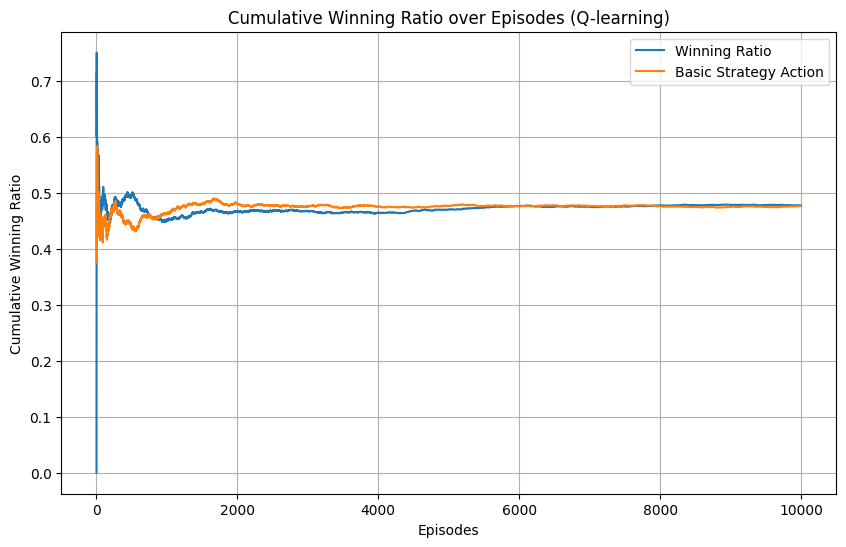

In [ ]:
class BlackjackEnvironment:
    def __init__(self, alpha=0.1, epsilon_decay_rate=0.99, num_episodes=1000, gamma=0.9):
        self.card_values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
        self.Deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        self.ACTIONS = ['hit', 'stand']  # removed 'double' action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_decay_rate = epsilon_decay_rate
        self.Q = {}
        self.num_episodes = num_episodes
        self.win_count = 0
        self.lose_count = 0
        self.draw_count = 0
        self.cumulative_win = []
        self.epsilon_values = []  # list to store epsilon values over episodes

    def deal_card(self, deck):
        return deck.pop()

    def hand_value(self, hand):
        value = sum(self.card_values[card] for card in hand)
        num_aces = hand.count('A')
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        return value

    def initialize_game(self):
        deck = self.Deck.copy()
        random.shuffle(deck)
        player_hand = [self.deal_card(deck), self.deal_card(deck)]
        dealer_hand = [self.deal_card(deck), self.deal_card(deck)]
        return deck, player_hand, dealer_hand

    def dealer_turn(self, deck, dealer_hand):
        while self.hand_value(dealer_hand) < 17:
            dealer_hand.append(self.deal_card(deck))
        return dealer_hand, self.hand_value(dealer_hand)

    def get_state(self, player_hand, dealer_card):
        return (self.hand_value(player_hand), dealer_card, bool('A' in player_hand))

    def step(self, deck, player_hand, dealer_hand, action):
        if action == 'hit':
            player_hand.append(self.deal_card(deck))
            if self.hand_value(player_hand) > 21:
                reward = -1
                executed = True
            else:
                next_state = self.get_state(player_hand, dealer_hand[0])
                reward = 0
                executed = False
        else:  # action == 'stand'
            dealer_hand, dealer_total = self.dealer_turn(deck, dealer_hand)
            player_total = self.hand_value(player_hand)
            if dealer_total > 21 or player_total > dealer_total:
                reward = 1
            elif player_total < dealer_total:
                reward = -1
            else:
                reward = 0
            executed = True

        if executed:
            state = self.get_state(player_hand, dealer_hand[0])
            if state not in self.Q:
                self.Q[state] = [0, 0]  # Adjusted for 2 actions ('hit', 'stand')
            self.Q[state][self.ACTIONS.index(action)] += self.alpha * (reward - self.Q[state][self.ACTIONS.index(action)])

            if reward == 1:
                self.win_count += 1
            elif reward == -1:
                self.lose_count += 1
            else:
                self.draw_count += 1

            self.cumulative_win.append((self.win_count + 0.5 * self.draw_count) / (self.episode + 1))

        return deck, player_hand, dealer_hand, reward, executed

    def reset(self):
        self.episode = 0
        self.Q = {}
        self.win_count = 0
        self.lose_count = 0
        self.draw_count = 0
        self.cumulative_win = []
        self.epsilon_values = []  # reset epsilon values

    def run_episodes(self):
        self.reset()
        epsilon = 1.0  # initialize epsilon
        for self.episode in range(self.num_episodes):
            deck, player_hand, dealer_hand = self.initialize_game()
            state = self.get_state(player_hand, dealer_hand[0])

            executed = False
            while not executed:
                if random.uniform(0, 1) < epsilon:
                    action = self.basic_strategy_action(player_hand, dealer_hand[0])
                else:
                    if state not in self.Q:
                        self.Q[state] = [0, 0]
                    action = self.ACTIONS[np.argmax(self.Q[state])]

                deck, player_hand, dealer_hand, reward, executed = self.step(deck, player_hand, dealer_hand, action)

                if not executed:
                    next_state = self.get_state(player_hand, dealer_hand[0])
                    if state not in self.Q:
                        self.Q[state] = [0, 0]
                    if next_state not in self.Q:
                        self.Q[next_state] = [0, 0]
                    self.Q[state][self.ACTIONS.index(action)] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][self.ACTIONS.index(action)])
                    state = next_state

            epsilon *= self.epsilon_decay_rate  # decay epsilon
            epsilon = max(epsilon, 0.1)  # Ensure epsilon doesn't go below 0.1
            self.epsilon_values.append(epsilon)  # Store epsilon value for plotting

        print(f"Results after {self.num_episodes} episodes:")
        print(f"Wins: {self.win_count}")
        print(f"Loses: {self.lose_count}")
        print(f"Draws: {self.draw_count}")

        win_percentage = (self.win_count / self.num_episodes) * 100
        print(f"Win Percentage: {win_percentage:.2f}%")

        # No plotting inside the class

    def basic_strategy_action(self, player_hand, dealer_card):
        player_total = self.hand_value(player_hand)
        if player_total <= 8:
            return 'hit'
        elif player_total >= 17:
            return 'stand'
        elif player_total == 9:
            if dealer_card in ['2', '3', '4', '5', '6']:
                return 'hit'
            else:
                return 'hit'
        elif player_total == 10 or player_total == 11:
            if dealer_card == 'A' or dealer_card == '10':
                return 'hit'
            else:
                return 'hit'
        elif player_total >= 12 and player_total <= 16:
            if dealer_card in ['2', '3', '4', '5', '6']:
                return 'stand'
            else:
                return 'hit'
        else:
            return 'hit'

# set parameters and run the Blackjack environment
alpha = 0.1
epsilon_decay_rate = 0.99999
num_episodes = 10000
gamma = 0.9

env = BlackjackEnvironment(alpha=alpha, epsilon_decay_rate=epsilon_decay_rate, num_episodes=num_episodes, gamma=gamma)
env.run_episodes()

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, num_episodes + 1), env.cumulative_win, label='Winning Ratio')
plt.plot(np.arange(1, num_episodes + 1), cumulative_win, label='Basic Strategy Action')
plt.title('Cumulative Winning Ratio over Episodes (Basic Strategy)')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Winning Ratio')
plt.title('Cumulative Winning Ratio over Episodes (Q-learning)')
plt.legend()
plt.grid(True)
plt.show()

Results after 50000 episodes (SARSA):
Wins: 18647
Losses: 27479
Draws: 3874
----------------------------------------
Win Percentage: 37.29%
Lose Percentage: 54.96%
Draw Percentage: 7.75%


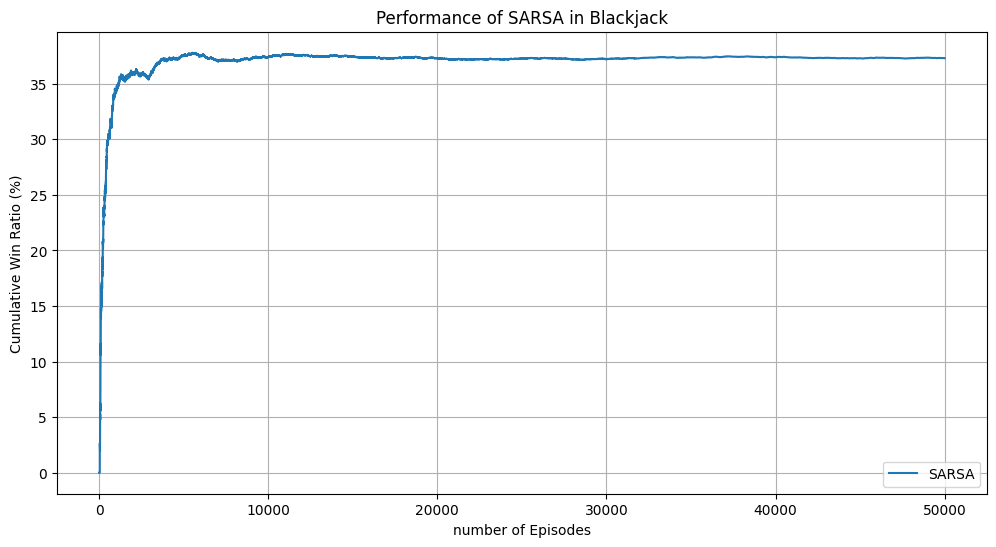

In [ ]:
class BlackjackEnvironment:
    def __init__(self):
        self.card_values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
        self.Deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        self.ACTIONS = ['hit', 'stand']
        self.q_table = {}  # initialize Q-table
        self.alpha = 0.1  # learning rate
        self.gamma = 0.9  # discount factor
        self.epsilon = 0.1  # Exploration rate

    def deal_card(self, deck):
        return deck.pop()

    def hand_value(self, hand):
        value = sum(self.card_values[card] for card in hand)
        num_aces = hand.count('A')
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        return value

    def initialize_game(self):
        deck = self.Deck.copy()
        random.shuffle(deck)
        player_hand = [self.deal_card(deck), self.deal_card(deck)]
        dealer_hand = [self.deal_card(deck), self.deal_card(deck)]
        return deck, player_hand, dealer_hand

    def dealer_turn(self, deck, dealer_hand):
        while self.hand_value(dealer_hand) < 17:
            dealer_hand.append(self.deal_card(deck))
        return dealer_hand, self.hand_value(dealer_hand)

    def get_state(self, player_hand, dealer_card):
        return (self.hand_value(player_hand), dealer_card, bool('A' in player_hand))

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice(self.ACTIONS)
        else:
            q_values = self.q_table.get(state, {action: 0 for action in self.ACTIONS})
            return max(q_values, key=q_values.get)

    def step(self, deck, player_hand, dealer_hand, action):
        if action == 'hit':
            player_hand.append(self.deal_card(deck))
            if self.hand_value(player_hand) > 21:
                reward = -1
                executed = True
            else:
                reward = 0
                executed = False
        else:  # action == 'stand'
            dealer_hand, dealer_total = self.dealer_turn(deck, dealer_hand)
            player_total = self.hand_value(player_hand)
            if dealer_total > 21 or player_total > dealer_total:
                reward = 1
            elif player_total < dealer_total:
                reward = -1
            else:
                reward = 0
            executed = True

        return deck, player_hand, dealer_hand, reward, executed

    def update_q_table(self, state, action, reward, next_state, next_action):
        q_values = self.q_table.setdefault(state, {action: 0 for action in self.ACTIONS})
        next_q_values = self.q_table.setdefault(next_state, {action: 0 for action in self.ACTIONS})
        q_values[action] += self.alpha * (reward + self.gamma * next_q_values[next_action] - q_values[action])

    def run_episodes(self, num_episodes):
        win_count = 0
        lose_count = 0
        draw_count = 0
        cumulative_win = []

        for episode in range(num_episodes):
            deck, player_hand, dealer_hand = self.initialize_game()
            state = self.get_state(player_hand, dealer_hand[0])
            action = self.get_action(state)
            executed = False

            while not executed:
                deck, player_hand, dealer_hand, reward, executed = self.step(deck, player_hand, dealer_hand, action)
                next_state = self.get_state(player_hand, dealer_hand[0])
                next_action = self.get_action(next_state)
                self.update_q_table(state, action, reward, next_state, next_action)

                state, action = next_state, next_action

            if reward == 1:
                win_count += 1
            elif reward == -1:
                lose_count += 1
            else:
                draw_count += 1

            # Compute cumulative win ratio as a percentage
            cumulative_win.append((win_count / (episode + 1)) * 100)

        total_games = win_count + lose_count + draw_count
        win_percentage = (win_count / total_games) * 100
        lose_percentage = (lose_count / total_games) * 100
        draw_percentage = (draw_count / total_games) * 100

        print(f"Results after {num_episodes} episodes (SARSA):")
        print(f"Wins: {win_count}")
        print(f"Losses: {lose_count}")
        print(f"Draws: {draw_count}")
        print("----------------------------------------")
        print(f"Win Percentage: {win_percentage:.2f}%")
        print(f"Lose Percentage: {lose_percentage:.2f}%")
        print(f"Draw Percentage: {draw_percentage:.2f}%")

        return cumulative_win

    def basic_strategy_action(self, player_hand, dealer_card):
        player_total = self.hand_value(player_hand)
        if player_total <= 8:
            return 'hit'
        elif player_total >= 17:
            return 'stand'
        elif player_total == 9:
            if dealer_card in ['2', '3', '4', '5', '6']:
                return 'hit'
            else:
                return 'hit'
        elif player_total == 10 or player_total == 11:
            if dealer_card == 'A' or dealer_card == '10':
                return 'hit'
            else:
                return 'hit'
        elif player_total >= 12 and player_total <= 16:
            if dealer_card in ['2', '3', '4', '5', '6']:
                return 'stand'
            else:
                return 'hit'
        else:
            return 'hit'

# set parameters and run the Blackjack environment
num_episodes = 50000

env = BlackjackEnvironment()
cumulative_win = env.run_episodes(num_episodes)

# plotting the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(cumulative_win)), cumulative_win, label='SARSA')
plt.xlabel('number of Episodes')
plt.ylabel('Cumulative Win Ratio (%)')
plt.title('Performance of SARSA in Blackjack')
plt.legend()
plt.grid(True)
plt.show()


### ⭐ **Complete  point count strategy**

Results after 10000 episodes:
Wins: 4025
Loses: 5075
Draws: 900
Win Percentage: 40.25%


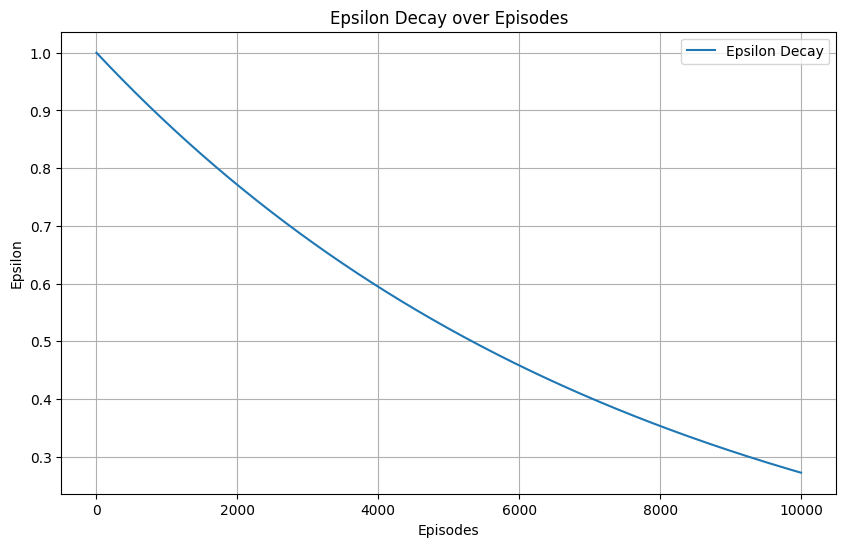

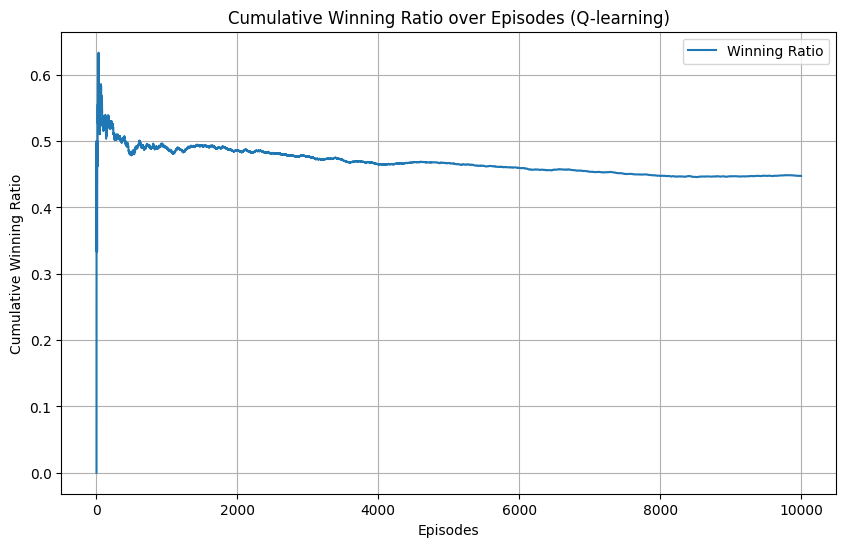

In [ ]:
class BlackjackEnvironment:
    def __init__(self, alpha=0.1, epsilon_decay_rate=0.99, num_episodes=1000, gamma=0.9):
        self.card_values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
        self.Deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        self.ACTIONS = ['hit', 'stand']
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_decay_rate = epsilon_decay_rate
        self.Q = {}
        self.num_episodes = num_episodes
        self.win_count = 0
        self.lose_count = 0
        self.draw_count = 0
        self.cumulative_win = []
        self.epsilon_values = []

    def deal_card(self, deck):
        return deck.pop()

    def hand_value(self, hand):
        value = sum(self.card_values[card] for card in hand)
        num_aces = hand.count('A')
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        return value

    def initialize_game(self):
        deck = self.Deck.copy()
        random.shuffle(deck)
        player_hand = [self.deal_card(deck), self.deal_card(deck)]
        dealer_hand = [self.deal_card(deck), self.deal_card(deck)]
        return deck, player_hand, dealer_hand

    def dealer_turn(self, deck, dealer_hand):
        while self.hand_value(dealer_hand) < 17:
            dealer_hand.append(self.deal_card(deck))
        return dealer_hand, self.hand_value(dealer_hand)

    def get_state(self, player_hand, dealer_card):
        return (self.hand_value(player_hand), dealer_card, bool('A' in player_hand))

    def step(self, deck, player_hand, dealer_hand, action):
        if action == 'hit':
            player_hand.append(self.deal_card(deck))
            if self.hand_value(player_hand) > 21:
                reward = -1
                executed = True
            else:
                next_state = self.get_state(player_hand, dealer_hand[0])
                reward = 0
                executed = False
        else:  # action == 'stand'
            dealer_hand, dealer_total = self.dealer_turn(deck, dealer_hand)
            player_total = self.hand_value(player_hand)
            if dealer_total > 21 or player_total > dealer_total:
                reward = 1
            elif player_total < dealer_total:
                reward = -1
            else:
                reward = 0
            executed = True

        if executed:
            state = self.get_state(player_hand, dealer_hand[0])
            if state not in self.Q:
                self.Q[state] = [0, 0]
            self.Q[state][self.ACTIONS.index(action)] += self.alpha * (reward - self.Q[state][self.ACTIONS.index(action)])

            if reward == 1:
                self.win_count += 1
            elif reward == -1:
                self.lose_count += 1
            else:
                self.draw_count += 1

            self.cumulative_win.append((self.win_count + 0.5 * self.draw_count) / (self.episode + 1))

        return deck, player_hand, dealer_hand, reward, executed

    def reset(self):
        self.episode = 0
        self.Q = {}
        self.win_count = 0
        self.lose_count = 0
        self.draw_count = 0
        self.cumulative_win = []
        self.epsilon_values = []

    def complete_point_count_action(self, player_hand, dealer_card, running_count):
        player_total = self.hand_value(player_hand)
        dealer_upcard = self.card_values[dealer_card]

        # Example point count system (Hi-Lo)
        if running_count >= 1:
            if player_total >= 17:
                return 'stand'
            elif player_total <= 12:
                return 'hit'
            elif player_total == 13 or player_total == 14:
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
            else:
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
        elif running_count <= -1:
            if player_total >= 17:
                return 'stand'
            elif player_total <= 12:
                return 'hit'
            elif player_total == 13 or player_total == 14:
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
            else:
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
        else:
            return random.choice(['hit', 'stand'])

    def update_running_count(self, card):
        if card in ['2', '3', '4', '5', '6']:
            return 1
        elif card in ['10', 'J', 'Q', 'K', 'A']:
            return -1
        else:
            return 0

    def run_episodes(self):
        self.reset()
        epsilon = 1.0
        running_count = 0
        for self.episode in range(self.num_episodes):
            deck, player_hand, dealer_hand = self.initialize_game()
            state = self.get_state(player_hand, dealer_hand[0])

            for card in player_hand + dealer_hand:
                running_count += self.update_running_count(card)

            executed = False
            while not executed:
                if random.uniform(0, 1) < epsilon:
                    action = self.complete_point_count_action(player_hand, dealer_hand[0], running_count)
                else:
                    if state not in self.Q:
                        self.Q[state] = [0, 0]
                    action = self.ACTIONS[np.argmax(self.Q[state])]

                deck, player_hand, dealer_hand, reward, executed = self.step(deck, player_hand, dealer_hand, action)

                if not executed:
                    next_state = self.get_state(player_hand, dealer_hand[0])
                    if state not in self.Q:
                        self.Q[state] = [0, 0]
                    if next_state not in self.Q:
                        self.Q[next_state] = [0, 0]
                    self.Q[state][self.ACTIONS.index(action)] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][self.ACTIONS.index(action)])
                    state = next_state

                running_count += self.update_running_count(player_hand[-1])

            epsilon *= self.epsilon_decay_rate
            epsilon = max(epsilon, 0.1)

            self.epsilon_values.append(epsilon)

        print(f"Results after {self.num_episodes} episodes:")
        print(f"Wins: {self.win_count}")
        print(f"Loses: {self.lose_count}")
        print(f"Draws: {self.draw_count}")

        win_percentage = (self.win_count / self.num_episodes) * 100
        print(f"Win Percentage: {win_percentage:.2f}%")

        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, self.num_episodes + 1), self.epsilon_values, label='Epsilon Decay')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon')
        plt.title('Epsilon Decay over Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, self.num_episodes + 1), self.cumulative_win, label='Winning Ratio')
        plt.xlabel('Episodes')
        plt.ylabel('Cumulative Winning Ratio')
        plt.title('Cumulative Winning Ratio over Episodes (Q-learning)')
        plt.legend()
        plt.grid(True)
        plt.show()

# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon_decay_rate = 0.99987
num_episodes = 10000

# Create the Blackjack environment
blackjack_env = BlackjackEnvironment(alpha=alpha, epsilon_decay_rate=epsilon_decay_rate, num_episodes=num_episodes, gamma=gamma)

# Run episodes
blackjack_env.run_episodes()


### ⭐ **Basic strategy** with variations **Double Down** and **Soft hand 17**

In [ ]:
class BlackjackEnvironment:
    def __init__(self, epsilon_decay_rate=0.99, num_episodes=1000, gamma=0.9):
        self.card_values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
        self.Deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        self.ACTIONS = ['hit', 'stand', 'double']
        self.alpha = 0.1
        self.gamma = gamma
        self.epsilon_decay_rate = epsilon_decay_rate
        self.Q = {}
        self.num_episodes = num_episodes
        self.win_count = 0
        self.lose_count = 0
        self.draw_count = 0
        self.cumulative_win = []
        self.epsilon_values = []

    def deal_card(self, deck):
        return deck.pop()

    def hand_value(self, hand):
        value = sum(self.card_values[card] for card in hand)
        num_aces = hand.count('A')
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        return value

    def is_soft_hand(self, hand):
        value = sum(self.card_values[card] for card in hand)
        return 'A' in hand and value <= 21 and value - 10 < 21

    def initialize_game(self):
        deck = self.Deck.copy()
        random.shuffle(deck)
        player_hand = [self.deal_card(deck), self.deal_card(deck)]
        dealer_hand = [self.deal_card(deck), self.deal_card(deck)]
        return deck, player_hand, dealer_hand

    def dealer_turn(self, deck, dealer_hand):
        while True:
            dealer_total = self.hand_value(dealer_hand)
            if dealer_total > 17 or (dealer_total == 17 and not self.is_soft_hand(dealer_hand)):
                break
            dealer_hand.append(self.deal_card(deck))
        return dealer_hand, self.hand_value(dealer_hand)

    def get_state(self, player_hand, dealer_card):
        return (self.hand_value(player_hand), dealer_card, self.is_soft_hand(player_hand))

    def step(self, deck, player_hand, dealer_hand, action):
        if action not in self.ACTIONS:
            raise ValueError(f"Invalid action: {action}")

        if action == 'hit':
            player_hand.append(self.deal_card(deck))
            if self.hand_value(player_hand) > 21:
                reward = -1
                executed = True
            else:
                next_state = self.get_state(player_hand, dealer_hand[0])
                reward = 0
                executed = False
        elif action == 'stand':
            dealer_hand, dealer_total = self.dealer_turn(deck, dealer_hand)
            player_total = self.hand_value(player_hand)
            if dealer_total > 21 or player_total > dealer_total:
                reward = 1
            elif player_total < dealer_total:
                reward = -1
            else:
                reward = 0
            executed = True
        elif action == 'double':
            player_hand.append(self.deal_card(deck))
            reward = 0
            dealer_hand, dealer_total = self.dealer_turn(deck, dealer_hand)
            player_total = self.hand_value(player_hand)
            if dealer_total > 21 or player_total > dealer_total:
                reward = 2
            elif player_total < dealer_total:
                reward = -2
            else:
                reward = 0
            executed = True

        if executed:
            state = self.get_state(player_hand, dealer_hand[0])
            if state not in self.Q:
                self.Q[state] = [0, 0, 0]
            self.Q[state][self.ACTIONS.index(action)] += self.alpha * (reward - self.Q[state][self.ACTIONS.index(action)])

            player_score = self.hand_value(player_hand)
            dealer_score = self.hand_value(dealer_hand)
            if reward > 0:
                game_status = 'win'
            elif reward < 0:
                game_status = 'lose'
            else:
                game_status = 'draw'

            q_value = self.Q[state][self.ACTIONS.index(action)]

            if game_status == 'win':
                self.win_count += 1
            elif game_status == 'lose':
                self.lose_count += 1
            else:
                self.draw_count += 1

            self.cumulative_win.append((self.win_count + 0.5 * self.draw_count) / (self.episode + 1))

        return deck, player_hand, dealer_hand, reward, executed

    def reset(self):
        self.episode = 0
        self.Q = {}
        self.win_count = 0
        self.lose_count = 0
        self.draw_count = 0
        self.cumulative_win = []
        self.epsilon_values = []

    def run_episodes(self):
        self.reset()
        epsilon = 1.0
        for self.episode in range(self.num_episodes):
            deck, player_hand, dealer_hand = self.initialize_game()
            state = self.get_state(player_hand, dealer_hand[0])

            executed = False
            while not executed:
                if random.uniform(0, 1) < epsilon:
                    action = self.basic_strategy_action(player_hand, dealer_hand[0])
                else:
                    if state not in self.Q:
                        self.Q[state] = [0, 0, 0]
                    action = self.ACTIONS[np.argmax(self.Q[state])]

                # print(f"Episode: {self.episode}, Action: {action}, State: {state}")  # Debug statement
                deck, player_hand, dealer_hand, reward, executed = self.step(deck, player_hand, dealer_hand, action)

                if not executed:
                    next_state = self.get_state(player_hand, dealer_hand[0])
                    if state not in self.Q:
                        self.Q[state] = [0, 0, 0]
                    if next_state not in self.Q:
                        self.Q[next_state] = [0, 0, 0]
                    self.Q[state][self.ACTIONS.index(action)] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][self.ACTIONS.index(action)])
                    state = next_state

            epsilon *= self.epsilon_decay_rate
            epsilon = max(epsilon, 0.1)
            self.epsilon_values.append(epsilon)

        print(f"Results after {self.num_episodes} episodes:")
        print(f"Wins: {self.win_count}")
        print(f"Loses: {self.lose_count}")
        print(f"Draws: {self.draw_count}")

        win_percentage = (self.win_count / self.num_episodes) * 100
        print(f"Win Percentage: {win_percentage:.2f}%")

        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, self.num_episodes + 1), self.epsilon_values, label='Epsilon Decay')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon')
        plt.title('Epsilon Decay over Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, self.num_episodes + 1), self.cumulative_win, label='Winning Ratio')
        plt.xlabel('Episodes')
        plt.ylabel('Cumulative Winning Ratio')
        plt.title('Cumulative Winning Ratio over Episodes (Q-learning)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def basic_strategy_action(self, player_hand, dealer_card):
        player_total = self.hand_value(player_hand)
        if player_total <= 8:
            return 'hit'
        elif player_total >= 17 and not self.is_soft_hand(player_hand):
            return 'stand'
        elif player_total == 9:
            if dealer_card in ['2', '3', '4', '5', '6']:
                return 'double' if 'double' in self.ACTIONS else 'hit'
            else:
                return 'hit'
        elif player_total == 10 or player_total == 11:
            if dealer_card == 'A' or dealer_card == '10':
                return 'hit'
            else:
                return 'double' if 'double' in self.ACTIONS else 'hit'
        elif player_total >= 12 and player_total <= 16:
            if dealer_card in ['2', '3', '4', '5', '6']:
                return 'stand'
            else:
                return 'hit'
        elif self.is_soft_hand(player_hand):
            if player_total == 13 or player_total == 14:
                if dealer_card in ['5', '6']:
                    return 'double' if 'double' in self.ACTIONS else 'hit'
                else:
                    return 'hit'
            elif player_total == 15 or player_total == 16:
                if dealer_card in ['4', '5', '6']:
                    return 'double' if 'double' in self.ACTIONS else 'hit'
                else:
                    return 'hit'
            elif player_total == 17:
                if dealer_card in ['3', '4', '5', '6']:
                    return 'double' if 'double' in self.ACTIONS else 'hit'
                else:
                    return 'hit'
            elif player_total >= 18:
                if dealer_card in ['2', '7', '8']:
                    return 'stand'
                else:
                    return 'hit'
        else:
            return 'stand'


Results after 100000 episodes:
Wins: 41216
Loses: 55295
Draws: 3489
Win Percentage: 41.22%


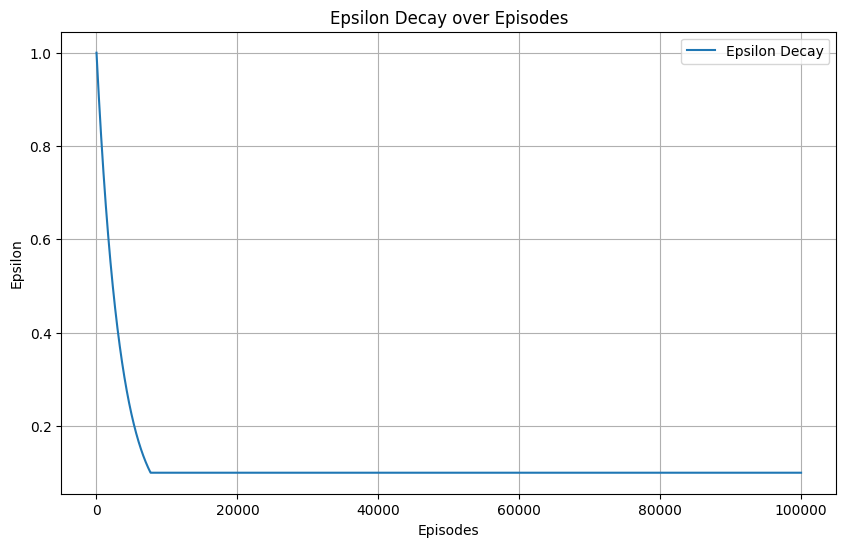

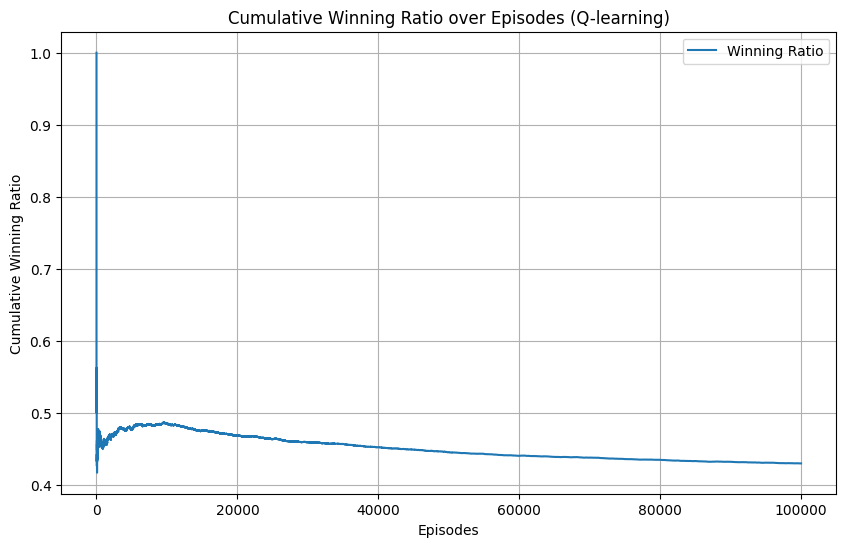

In [ ]:
# create the environment and run the episodes
epsilon_decay_rate = 0.9997
num_episodes = 100000
gamma = 0.9

env = BlackjackEnvironment(epsilon_decay_rate=epsilon_decay_rate, num_episodes=num_episodes, gamma=gamma)
env.run_episodes()

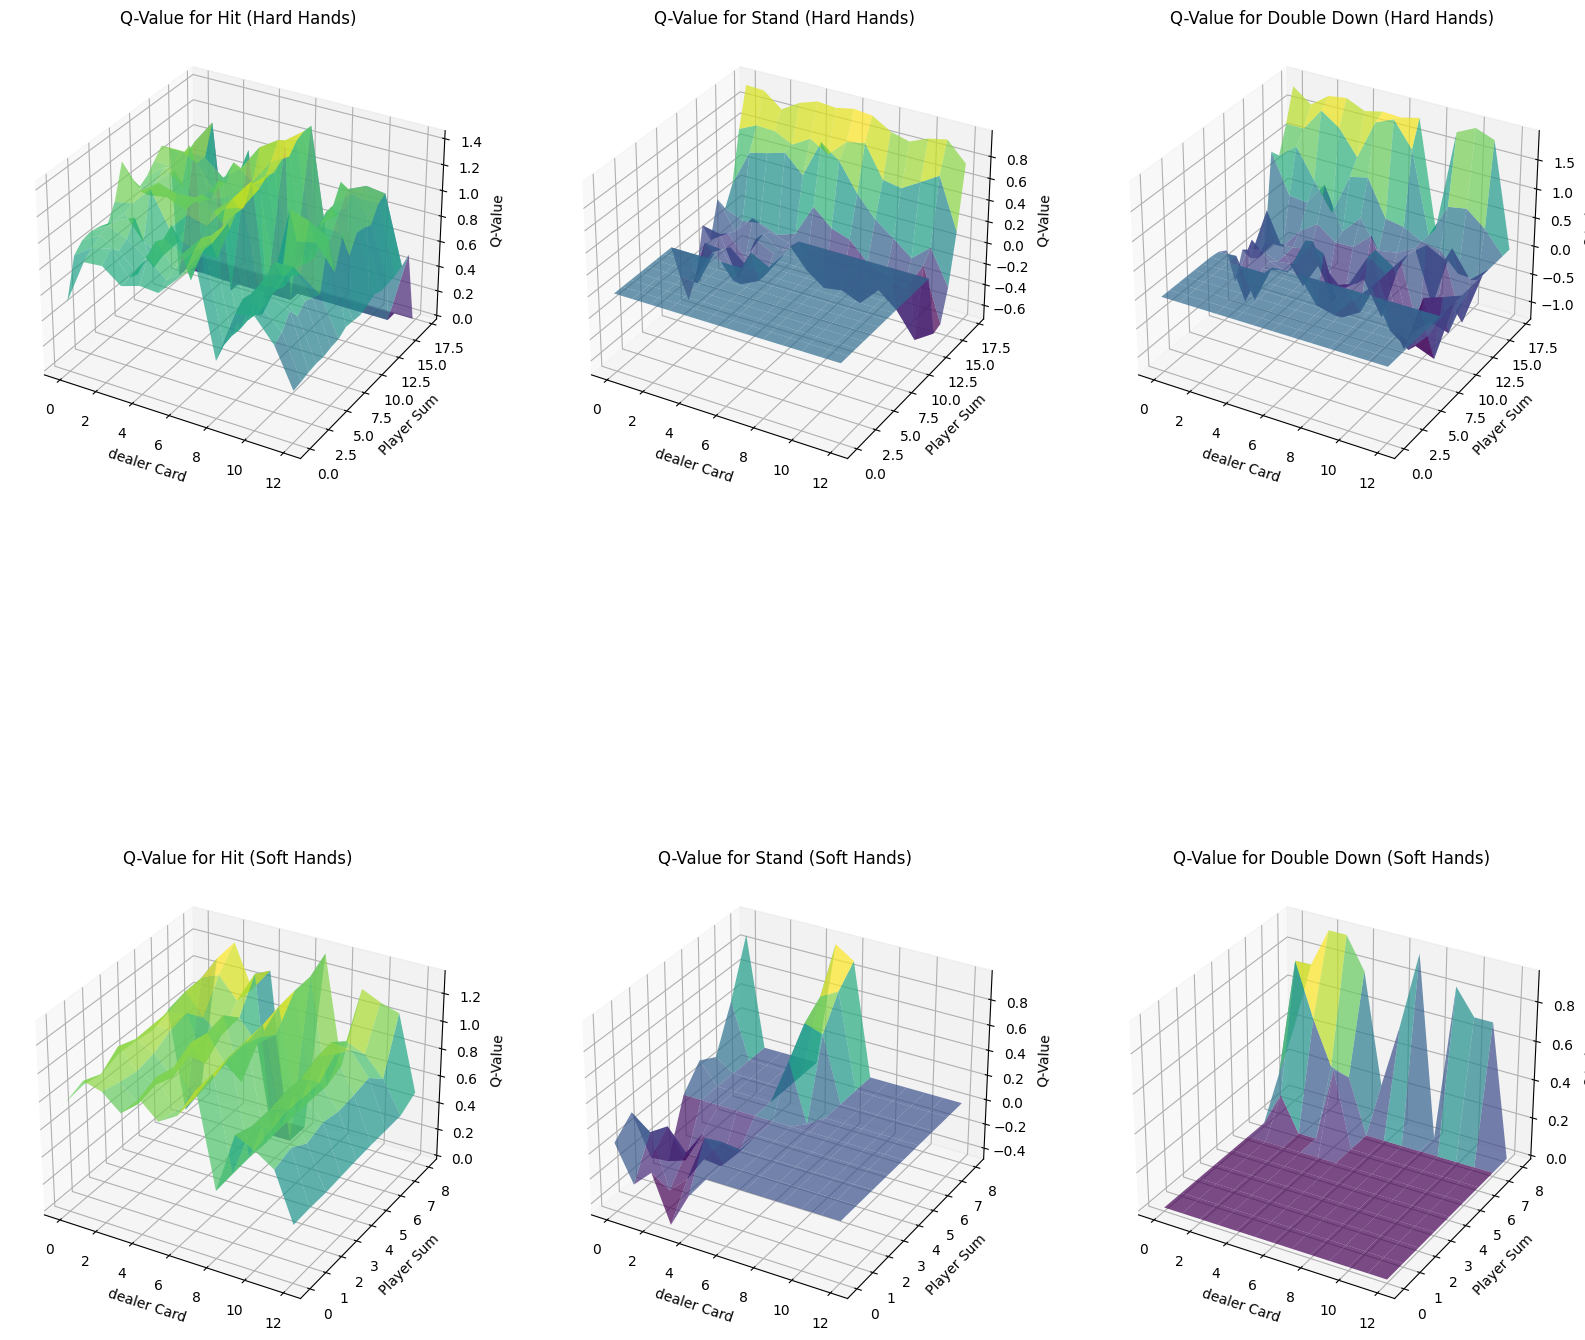

In [ ]:
def plot_q_values(Q):
    card_values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
    dealer_cards = list(card_values.keys())
    player_sums = range(4, 22)  # For hard hands
    soft_player_sums = range(13, 22)  # For soft hands (soft 13 to 21)

    q_values_hit = np.zeros((len(player_sums), len(dealer_cards)))
    q_values_stand = np.zeros((len(player_sums), len(dealer_cards)))
    q_values_double = np.zeros((len(player_sums), len(dealer_cards)))

    q_values_hit_soft = np.zeros((len(soft_player_sums), len(dealer_cards)))
    q_values_stand_soft = np.zeros((len(soft_player_sums), len(dealer_cards)))
    q_values_double_soft = np.zeros((len(soft_player_sums), len(dealer_cards)))

    ACTIONS = ['hit', 'stand', 'double']

    for i, player_sum in enumerate(player_sums):
        for j, dealer_card in enumerate(dealer_cards):
            state = (player_sum, dealer_card, False)
            if state in Q:
                q_values_hit[i, j] = Q[state][ACTIONS.index('hit')]
                q_values_stand[i, j] = Q[state][ACTIONS.index('stand')]
                q_values_double[i, j] = Q[state][ACTIONS.index('double')]

    for i, player_sum in enumerate(soft_player_sums):
        for j, dealer_card in enumerate(dealer_cards):
            state = (player_sum, dealer_card, True)
            if state in Q:
                q_values_hit_soft[i, j] = Q[state][ACTIONS.index('hit')]
                q_values_stand_soft[i, j] = Q[state][ACTIONS.index('stand')]
                q_values_double_soft[i, j] = Q[state][ACTIONS.index('double')]

    X, Y = np.meshgrid(range(len(dealer_cards)), range(len(player_sums)))
    X_soft, Y_soft = np.meshgrid(range(len(dealer_cards)), range(len(soft_player_sums)))

    fig = plt.figure(figsize=(20, 20))

    # Hard hands
    ax_hit = fig.add_subplot(231, projection='3d')
    surf_hit = ax_hit.plot_surface(X, Y, q_values_hit, cmap='viridis', alpha=0.7, edgecolor='none')
    ax_hit.set_xlabel('dealer Card')
    ax_hit.set_ylabel('Player Sum')
    ax_hit.set_zlabel('Q-Value')
    ax_hit.set_title('Q-Value for Hit (Hard Hands)')

    ax_stand = fig.add_subplot(232, projection='3d')
    surf_stand = ax_stand.plot_surface(X, Y, q_values_stand, cmap='viridis', alpha=0.7, edgecolor='none')
    ax_stand.set_xlabel('dealer Card')
    ax_stand.set_ylabel('Player Sum')
    ax_stand.set_zlabel('Q-Value')
    ax_stand.set_title('Q-Value for Stand (Hard Hands)')

    ax_double = fig.add_subplot(233, projection='3d')
    surf_double = ax_double.plot_surface(X, Y, q_values_double, cmap='viridis', alpha=0.7, edgecolor='none')
    ax_double.set_xlabel('dealer Card')
    ax_double.set_ylabel('Player Sum')
    ax_double.set_zlabel('Q-Value')
    ax_double.set_title('Q-Value for Double Down (Hard Hands)')

    # Soft hands
    ax_hit_soft = fig.add_subplot(234, projection='3d')
    surf_hit_soft = ax_hit_soft.plot_surface(X_soft, Y_soft, q_values_hit_soft, cmap='viridis', alpha=0.7, edgecolor='none')
    ax_hit_soft.set_xlabel('dealer Card')
    ax_hit_soft.set_ylabel('Player Sum')
    ax_hit_soft.set_zlabel('Q-Value')
    ax_hit_soft.set_title('Q-Value for Hit (Soft Hands)')

    ax_stand_soft = fig.add_subplot(235, projection='3d')
    surf_stand_soft = ax_stand_soft.plot_surface(X_soft, Y_soft, q_values_stand_soft, cmap='viridis', alpha=0.7, edgecolor='none')
    ax_stand_soft.set_xlabel('dealer Card')
    ax_stand_soft.set_ylabel('Player Sum')
    ax_stand_soft.set_zlabel('Q-Value')
    ax_stand_soft.set_title('Q-Value for Stand (Soft Hands)')

    ax_double_soft = fig.add_subplot(236, projection='3d')
    surf_double_soft = ax_double_soft.plot_surface(X_soft, Y_soft, q_values_double_soft, cmap='viridis', alpha=0.7, edgecolor='none')
    ax_double_soft.set_xlabel('dealer Card')
    ax_double_soft.set_ylabel('Player Sum')
    ax_double_soft.set_zlabel('Q-Value')
    ax_double_soft.set_title('Q-Value for Double Down (Soft Hands)')

    plt.show()

# plotting Q-values after training
plot_q_values(env.Q)

### ⭐ **Complete point count strategy** with variations **Double Down** and **Soft hand 17**

Results after 10000 episodes:
Wins: 4095
Loses: 5063
Draws: 842
Win Percentage: 40.95%


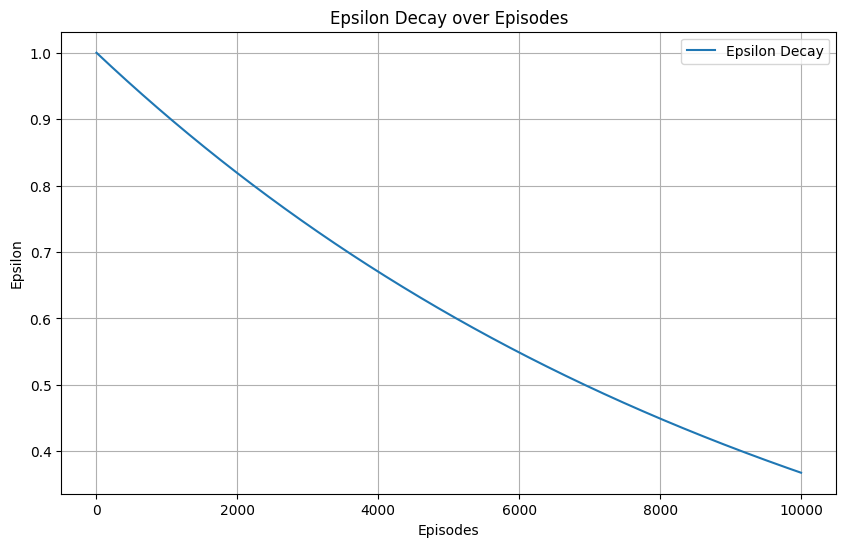

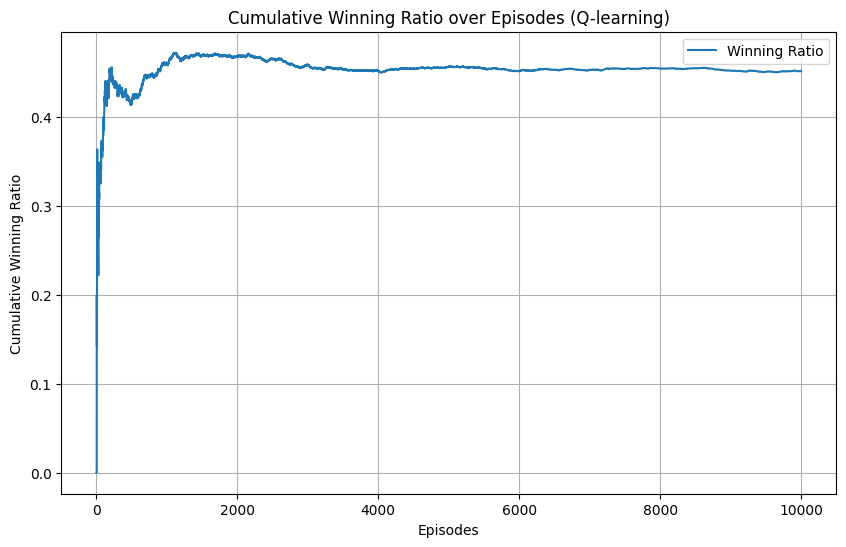

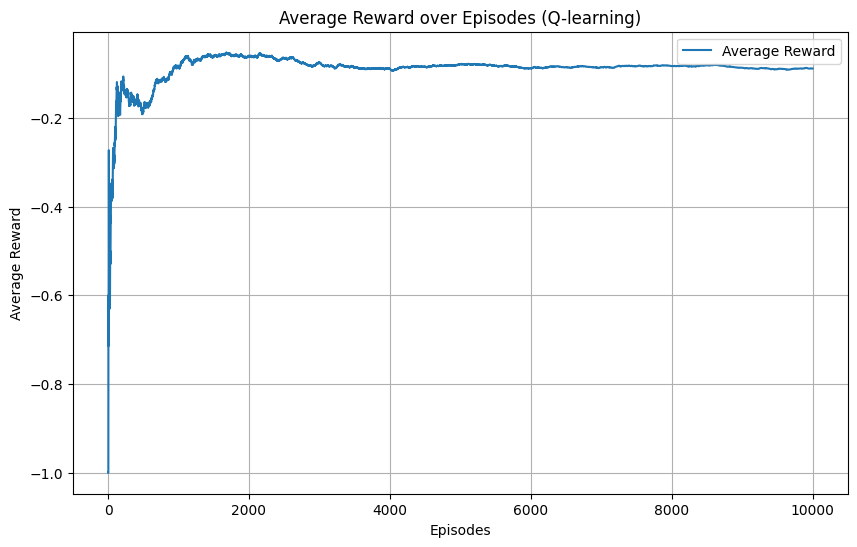

In [ ]:
class BlackjackEnvironment:
    def __init__(self, epsilon_decay_rate=0.99, num_episodes=1000, gamma=0.9, alpha=0.1):
        self.card_values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
        self.Deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4
        self.ACTIONS = ['hit', 'stand', 'double']  # Added 'double' action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_decay_rate = epsilon_decay_rate
        self.Q = {}
        self.num_episodes = num_episodes
        self.win_count = 0
        self.lose_count = 0
        self.draw_count = 0
        self.cumulative_win = []
        self.epsilon_values = []  # list to store epsilon values over episodes
        self.average_rewards = []  # list to store average rewards over episodes

    def deal_card(self, deck):
        return deck.pop()

    def hand_value(self, hand):
        value = sum(self.card_values[card] for card in hand)
        num_aces = hand.count('A')
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        return value

    def is_soft_hand(self, hand):
        value = sum(self.card_values[card] for card in hand)
        return 'A' in hand and value <= 21 and value - 10 < 21

    def initialize_game(self):
        deck = self.Deck.copy()
        random.shuffle(deck)
        player_hand = [self.deal_card(deck), self.deal_card(deck)]
        dealer_hand = [self.deal_card(deck), self.deal_card(deck)]
        return deck, player_hand, dealer_hand

    def dealer_turn(self, deck, dealer_hand):
        while True:
            dealer_total = self.hand_value(dealer_hand)
            if dealer_total > 17 or (dealer_total == 17 and not self.is_soft_hand(dealer_hand)):
                break
            dealer_hand.append(self.deal_card(deck))
        return dealer_hand, self.hand_value(dealer_hand)

    def get_state(self, player_hand, dealer_card, doubled=False):
        return (self.hand_value(player_hand), dealer_card, bool('A' in player_hand), doubled)

    def step(self, deck, player_hand, dealer_hand, action, doubled=False):
        if action == 'hit':
            player_hand.append(self.deal_card(deck))
            if self.hand_value(player_hand) > 21:
                reward = -1
                executed = True
            else:
                next_state = self.get_state(player_hand, dealer_hand[0], doubled)
                reward = 0
                executed = False
        elif action == 'stand':
            dealer_hand, dealer_total = self.dealer_turn(deck, dealer_hand)
            player_total = self.hand_value(player_hand)
            if dealer_total > 21 or player_total > dealer_total:
                reward = 1
            elif player_total < dealer_total:
                reward = -1
            else:
                reward = 0
            executed = True
        elif action == 'double':
            player_hand.append(self.deal_card(deck))
            if self.hand_value(player_hand) > 21:
                reward = -2  # Double down loss
            else:
                dealer_hand, dealer_total = self.dealer_turn(deck, dealer_hand)
                player_total = self.hand_value(player_hand)
                if dealer_total > 21 or player_total > dealer_total:
                    reward = 2  # Double down win
                elif player_total < dealer_total:
                    reward = -2  # Double down loss
                else:
                    reward = 0
            executed = True

        if executed:
            state = self.get_state(player_hand, dealer_hand[0], doubled)
            if state not in self.Q:
                self.Q[state] = [0] * len(self.ACTIONS)
            action_index = self.ACTIONS.index(action)
            self.Q[state][action_index] += self.alpha * (reward - self.Q[state][action_index])

            player_score = self.hand_value(player_hand)
            dealer_score = self.hand_value(dealer_hand)
            if reward > 0:
                game_status = 'win'
            elif reward < 0:
                game_status = 'lose'
            else:
                game_status = 'draw'

            if game_status == 'win':
                self.win_count += 1
            elif game_status == 'lose':
                self.lose_count += 1
            else:
                self.draw_count += 1

            self.cumulative_win.append((self.win_count + 0.5 * self.draw_count) / (self.episode + 1))

        return deck, player_hand, dealer_hand, reward, executed

    def reset(self):
        self.episode = 0
        self.Q = {}
        self.win_count = 0
        self.lose_count = 0
        self.draw_count = 0
        self.cumulative_win = []
        self.epsilon_values = []  # reset epsilon values
        self.average_rewards = []  # reset average rewards

    def complete_point_count_action(self, player_hand, dealer_card, running_count, doubled=False):
        player_total = self.hand_value(player_hand)
        dealer_upcard = self.card_values[dealer_card]

        # Adjusted strategy considering "double down"
        if running_count >= 1:
            if player_total == 11:
                return 'double'
            elif player_total == 10:
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'double'
                else:
                    return 'hit'
            elif player_total >= 17:
                return 'stand'
            elif player_total <= 12:
                return 'hit'
            elif player_total in [13, 14]:
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
            else:  # player_total == 15 or player_total == 16
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
        elif running_count <= -1:
            if player_total == 11:
                return 'double'
            elif player_total == 10:
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'double'
                else:
                    return 'hit'
            elif player_total >= 17:
                return 'stand'
            elif player_total <= 12:
                return 'hit'
            elif player_total in [13, 14]:
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
            else:  # player_total == 15 or player_total == 16
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
        else:
            if player_total == 11:
                return 'double'
            elif player_total == 10:
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'double'
                else:
                    return 'hit'
            elif player_total >= 17:
                return 'stand'
            elif player_total <= 12:
                return 'hit'
            elif player_total in [13, 14]:
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
            else:  # player_total == 15 or player_total == 16
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'

    def update_running_count(self, card):
        if card in ['2', '3', '4', '5', '6']:
            return 1
        elif card in ['10', 'J', 'Q', 'K', 'A']:
            return -1
        else:
            return 0

    def run_episodes(self):
        self.reset()
        epsilon = 1.0  # initialize epsilon
        running_count = 0  # initialize running count
        total_rewards = 0  # initialize total rewards for average calculation
        for self.episode in range(self.num_episodes):
            deck, player_hand, dealer_hand = self.initialize_game()
            state = self.get_state(player_hand, dealer_hand[0])

            # update running count with initial hands
            for card in player_hand + dealer_hand:
                running_count += self.update_running_count(card)

            executed = False
            doubled = False
            while not executed:
                if random.uniform(0, 1) < epsilon:
                    action = self.complete_point_count_action(player_hand, dealer_hand[0], running_count, doubled)
                else:
                    if state not in self.Q:
                        self.Q[state] = [0] * len(self.ACTIONS)
                    action = self.ACTIONS[np.argmax(self.Q[state])]

                if action == 'double':
                    if doubled:
                        raise ValueError("Double down action cannot be repeated.")
                    doubled = True

                deck, player_hand, dealer_hand, reward, executed = self.step(deck, player_hand, dealer_hand, action, doubled)

                if not executed:
                    next_state = self.get_state(player_hand, dealer_hand[0], doubled)
                    if state not in self.Q:
                        self.Q[state] = [0] * len(self.ACTIONS)
                    if next_state not in self.Q:
                        self.Q[next_state] = [0] * len(self.ACTIONS)
                    action_index = self.ACTIONS.index(action)
                    self.Q[state][action_index] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action_index])
                    state = next_state

                # update running count for each new card dealt
                if player_hand:  # Ensure player_hand is not empty
                    running_count += self.update_running_count(player_hand[-1])

            total_rewards += reward  # accumulate reward
            self.average_rewards.append(total_rewards / (self.episode + 1))  # calculate average reward

            epsilon *= self.epsilon_decay_rate  # decay epsilon
            epsilon = max(epsilon, 0.1)  # Ensure epsilon doesn't go below 0.1

            # update running count for cards seen
            for card in player_hand + dealer_hand:
                running_count += self.update_running_count(card)

            self.epsilon_values.append(epsilon)  # Store epsilon value for plotting

        print(f"Results after {self.num_episodes} episodes:")
        print(f"Wins: {self.win_count}")
        print(f"Loses: {self.lose_count}")
        print(f"Draws: {self.draw_count}")

        win_percentage = (self.win_count / self.num_episodes) * 100
        print(f"Win Percentage: {win_percentage:.2f}%")

        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, self.num_episodes + 1), self.epsilon_values, label='Epsilon Decay')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon')
        plt.title('Epsilon Decay over Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, self.num_episodes + 1), self.cumulative_win, label='Winning Ratio')
        plt.xlabel('Episodes')
        plt.ylabel('Cumulative Winning Ratio')
        plt.title('Cumulative Winning Ratio over Episodes (Q-learning)')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, self.num_episodes + 1), self.average_rewards, label='Average Reward')
        plt.xlabel('Episodes')
        plt.ylabel('Average Reward')
        plt.title('Average Reward over Episodes (Q-learning)')
        plt.legend()
        plt.grid(True)
        plt.show()

# hyperparameters
alpha = 0.1
gamma = 0.9
epsilon_decay_rate = 0.9999
num_episodes = 10000

# create the Blackjack environment
blackjack_env = BlackjackEnvironment(epsilon_decay_rate=epsilon_decay_rate, num_episodes=num_episodes, gamma=gamma, alpha=alpha)

# run episodes
blackjack_env.run_episodes()


### ⭐ **Complete point count strategy** with variations WITH DIFFERENT no. of Decks

Running simulation with 1 deck(s)...
Results after 10000 episodes with 1 deck(s):
Wins: 4061
Loses: 5044
Draws: 895
Win Percentage: 40.61%
Running simulation with 2 deck(s)...
Results after 10000 episodes with 2 deck(s):
Wins: 4118
Loses: 4986
Draws: 896
Win Percentage: 41.18%
Running simulation with 3 deck(s)...
Results after 10000 episodes with 3 deck(s):
Wins: 4065
Loses: 5063
Draws: 872
Win Percentage: 40.65%


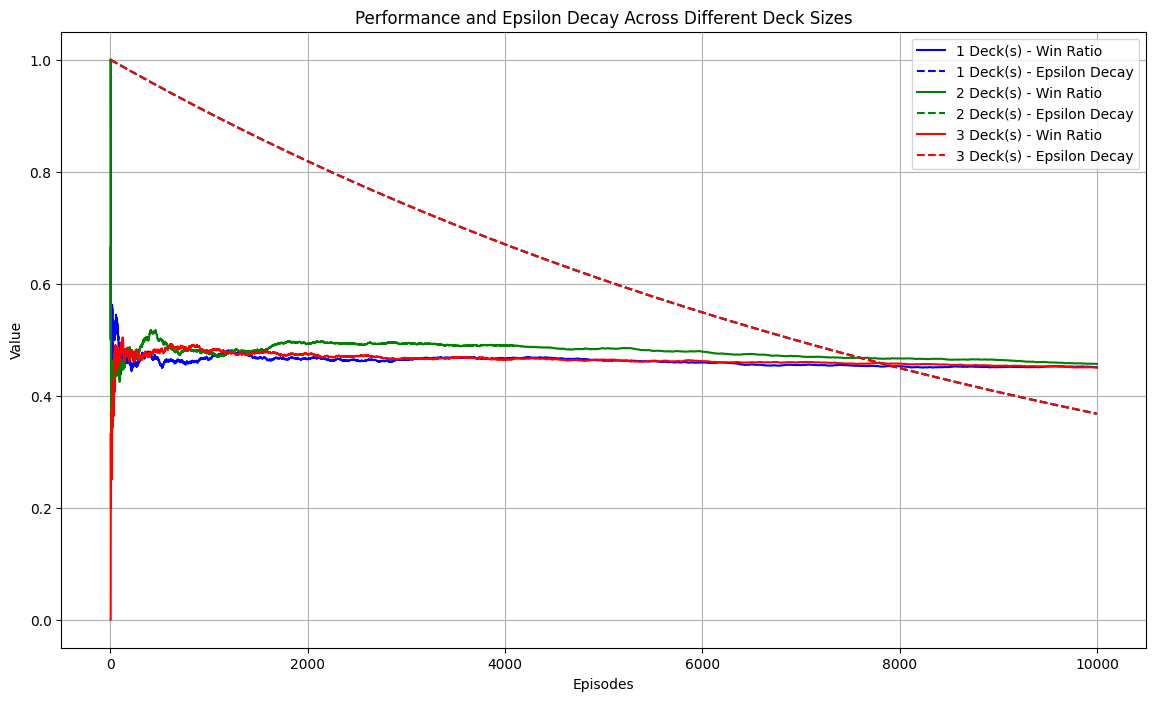

In [ ]:
class BlackjackEnvironment:
    def __init__(self, num_decks=1, epsilon_decay_rate=0.99, num_episodes=1000, gamma=0.9, alpha=0.1):
        self.num_decks = num_decks
        self.card_values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
        self.Deck = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'] * 4 * num_decks
        self.ACTIONS = ['hit', 'stand']  # removed 'double' action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_decay_rate = epsilon_decay_rate
        self.Q = {}
        self.num_episodes = num_episodes
        self.win_count = 0
        self.lose_count = 0
        self.draw_count = 0
        self.cumulative_win = []
        self.epsilon_values = []  # list to store epsilon values over episodes

    def deal_card(self, deck):
        return deck.pop()

    def hand_value(self, hand):
        value = sum(self.card_values[card] for card in hand)
        num_aces = hand.count('A')
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        return value

    def initialize_game(self):
        deck = self.Deck.copy()
        random.shuffle(deck)
        player_hand = [self.deal_card(deck), self.deal_card(deck)]
        dealer_hand = [self.deal_card(deck), self.deal_card(deck)]
        return deck, player_hand, dealer_hand

    def dealer_turn(self, deck, dealer_hand):
        while self.hand_value(dealer_hand) < 17:
            dealer_hand.append(self.deal_card(deck))
        return dealer_hand, self.hand_value(dealer_hand)

    def get_state(self, player_hand, dealer_card):
        return (self.hand_value(player_hand), dealer_card, bool('A' in player_hand))

    def step(self, deck, player_hand, dealer_hand, action):
        if action == 'hit':
            player_hand.append(self.deal_card(deck))
            if self.hand_value(player_hand) > 21:
                reward = -1
                executed = True
            else:
                next_state = self.get_state(player_hand, dealer_hand[0])
                reward = 0
                executed = False
        else:  # action == 'stand'
            dealer_hand, dealer_total = self.dealer_turn(deck, dealer_hand)
            player_total = self.hand_value(player_hand)
            if dealer_total > 21 or player_total > dealer_total:
                reward = 1
            elif player_total < dealer_total:
                reward = -1
            else:
                reward = 0
            executed = True

        if executed:
            state = self.get_state(player_hand, dealer_hand[0])
            if state not in self.Q:
                self.Q[state] = [0, 0]  # Adjusted for 2 actions ('hit', 'stand')
            self.Q[state][self.ACTIONS.index(action)] += self.alpha * (reward - self.Q[state][self.ACTIONS.index(action)])

            player_score = self.hand_value(player_hand)
            dealer_score = self.hand_value(dealer_hand)
            if reward == 1:
                game_status = 'win'
            elif reward == -1:
                game_status = 'lose'
            else:
                game_status = 'draw'

            q_value = self.Q[state][self.ACTIONS.index(action)]

            if game_status == 'win':
                self.win_count += 1
            elif game_status == 'lose':
                self.lose_count += 1
            else:
                self.draw_count += 1

            self.cumulative_win.append((self.win_count + 0.5 * self.draw_count) / (self.episode + 1))

        return deck, player_hand, dealer_hand, reward, executed

    def reset(self):
        self.episode = 0
        self.Q = {}
        self.win_count = 0
        self.lose_count = 0
        self.draw_count = 0
        self.cumulative_win = []
        self.epsilon_values = []  # reset epsilon values

    def complete_point_count_action(self, player_hand, dealer_card, running_count):
        player_total = self.hand_value(player_hand)
        dealer_upcard = self.card_values[dealer_card]

        # Example point count system (Hi-Lo)
        if running_count >= 1:
            # Favorable count for player, consider standing more often
            if player_total >= 17:
                return 'stand'
            elif player_total <= 12:
                return 'hit'
            elif player_total == 13 or player_total == 14:
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
            else:  # player_total == 15 or player_total == 16
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
        elif running_count <= -1:
            # unfavorable count for player, consider hitting more conservatively
            if player_total >= 17:
                return 'stand'
            elif player_total <= 12:
                return 'hit'
            elif player_total == 13 or player_total == 14:
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
            else:  # player_total == 15 or player_total == 16
                if dealer_upcard in [2, 3, 4, 5, 6]:
                    return 'stand'
                else:
                    return 'hit'
        else:
            # Neutral count, use basic strategy
            return random.choice(['hit', 'stand'])

    def update_running_count(self, card):
        if card in ['2', '3', '4', '5', '6']:
            return 1
        elif card in ['10', 'J', 'Q', 'K', 'A']:
            return -1
        else:
            return 0

    def run_episodes(self):
        self.reset()
        epsilon = 1.0  # initialize epsilon
        running_count = 0  # initialize running count
        for self.episode in range(self.num_episodes):
            deck, player_hand, dealer_hand = self.initialize_game()
            state = self.get_state(player_hand, dealer_hand[0])

            # update running count with initial hands
            for card in player_hand + dealer_hand:
                running_count += self.update_running_count(card)

            executed = False
            while not executed:
                if random.uniform(0, 1) < epsilon:
                    action = self.complete_point_count_action(player_hand, dealer_hand[0], running_count)
                else:
                    if state not in self.Q:
                        self.Q[state] = [0, 0]
                    action = self.ACTIONS[np.argmax(self.Q[state])]

                deck, player_hand, dealer_hand, reward, executed = self.step(deck, player_hand, dealer_hand, action)

                if not executed:
                    next_state = self.get_state(player_hand, dealer_hand[0])
                    if state not in self.Q:
                        self.Q[state] = [0, 0]
                    if next_state not in self.Q:
                        self.Q[next_state] = [0, 0]
                    self.Q[state][self.ACTIONS.index(action)] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][self.ACTIONS.index(action)])
                    state = next_state

                # update running count for each new card dealt
                running_count += self.update_running_count(player_hand[-1])

            epsilon *= self.epsilon_decay_rate  # decay epsilon
            epsilon = max(epsilon, 0.1)  # Ensure epsilon doesn't go below 0.1

            # update running count for cards seen
            for card in player_hand + dealer_hand:
                running_count += self.update_running_count(card)

            self.epsilon_values.append(epsilon)  # Store epsilon value for plotting

        print(f"Results after {self.num_episodes} episodes with {self.num_decks} deck(s):")
        print(f"Wins: {self.win_count}")
        print(f"Loses: {self.lose_count}")
        print(f"Draws: {self.draw_count}")

        win_percentage = (self.win_count / self.num_episodes) * 100
        print(f"Win Percentage: {win_percentage:.2f}%")

        return self.cumulative_win, self.epsilon_values

# hyperparameters
alpha = 0.1
gamma = 0.9
epsilon_decay_rate = 0.9999
num_episodes = 10000

# list of deck numbers to test
deck_counts = [1, 2, 3]

# Prepare for plotting
colors = ['b', 'g', 'r', 'c']  # Define colors for each deck count
plt.figure(figsize=(14, 8))

for i, num_decks in enumerate(deck_counts):
    print(f"Running simulation with {num_decks} deck(s)...")
    blackjack_env = BlackjackEnvironment(num_decks=num_decks, epsilon_decay_rate=epsilon_decay_rate, num_episodes=num_episodes, gamma=gamma, alpha=alpha)
    cumulative_win, epsilon_values = blackjack_env.run_episodes()

    # plot cumulative win ratio
    plt.plot(np.arange(1, num_episodes + 1), cumulative_win, color=colors[i], label=f'{num_decks} Deck(s) - Win Ratio')
    # plot epsilon values
    plt.plot(np.arange(1, num_episodes + 1), epsilon_values, color=colors[i], linestyle='--', label=f'{num_decks} Deck(s) - Epsilon Decay')

# finalize plotting
plt.xlabel('Episodes')
plt.ylabel('Value')
plt.title('Performance and Epsilon Decay Across Different Deck Sizes')
plt.legend()
plt.grid(True)
plt.show()
